# AutoML

In [1]:
import sagemaker
import boto3
import os
import numpy as np
from sagemaker.automl.automl import AutoML
from matplotlib import pyplot as plt


sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'real-estate'

role = sagemaker.get_execution_role()

In [2]:
data_dir = 'data'
train_key = os.path.join(prefix, 'train/train.csv')
test_key = os.path.join(prefix, 'test/test.csv')

In [3]:
# boto3.Session().resource('s3').Bucket(bucket).Object(train_key).upload_file(os.path.join(data_dir, 'clean_data_november.csv'))
# boto3.Session().resource('s3').Bucket(bucket).Object(test_key).upload_file(os.path.join(data_dir, 'clean_data_december.csv'))

In [4]:
# automl_job = AutoML(
#     role=role,
#     target_attribute_name='eur_price',
#     problem_type='Regression',
#     job_objective={'MetricName': 'MSE'},
#     max_candidates=250
# )

In [5]:
# s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)

In [ ]:
# automl_job.fit(inputs=s3_input_train)

.........

# Deploying model

In [6]:
client = boto3.client('sagemaker')
automl_job_name = client.list_auto_ml_jobs()['AutoMLJobSummaries'][0]['AutoMLJobName']
automl_job = AutoML.attach(auto_ml_job_name=automl_job_name, sagemaker_session=sagemaker_session)

In [7]:
best_model_algo = automl_job.best_candidate()['InferenceContainers'][-1]['Image'].split('/')[-1]
best_mse = automl_job.best_candidate()['FinalAutoMLJobObjectiveMetric']['Value']
print(f'The best model is a {best_model_algo} with a MSE of {best_mse}')

The best model is a sagemaker-xgboost:1.2-2-cpu-py3 with a MSE of 9584455680.0


### Exploring all candidates

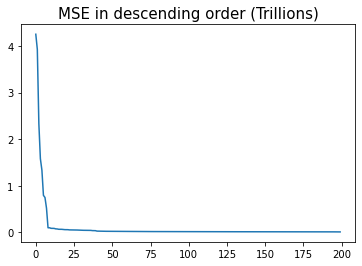

In [8]:
plt.plot(sorted([
    val['FinalAutoMLJobObjectiveMetric']['Value']/1000000000000 for val 
    in automl_job.list_candidates(max_results=100, sort_order='Descending', sort_by='FinalObjectiveMetricValue')
] + [
    val['FinalAutoMLJobObjectiveMetric']['Value']/1000000000000 for val 
    in automl_job.list_candidates(max_results=100, sort_order='Ascending', sort_by='FinalObjectiveMetricValue')
], reverse=True))
plt.title('MSE in descending order (Trillions)', fontsize=15);

In [9]:
all_candidates = automl_job.list_candidates(max_results=100, sort_order='Descending', sort_by='FinalObjectiveMetricValue') + automl_job.list_candidates(max_results=100, sort_order='Ascending', sort_by='FinalObjectiveMetricValue')

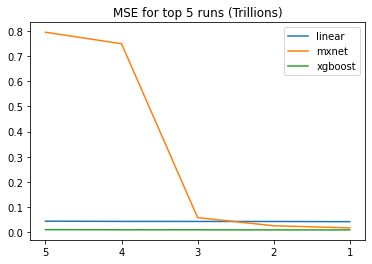

In [10]:
top_3_linear = sorted([val['FinalAutoMLJobObjectiveMetric']['Value']/1000000000000 for val in all_candidates if val['InferenceContainers'][-1]['Image'].split('/')[-1] == 'linear-learner:latest'], reverse=True)[-5:]
top_3_mxnet = sorted([val['FinalAutoMLJobObjectiveMetric']['Value']/1000000000000 for val in all_candidates if val['InferenceContainers'][-1]['Image'].split('/')[-1] == 'mxnet-algorithms:inference-cpu'], reverse=True)[-5:]
top_3_xgboost = sorted([val['FinalAutoMLJobObjectiveMetric']['Value']/1000000000000 for val in all_candidates if val['InferenceContainers'][-1]['Image'].split('/')[-1] == 'sagemaker-xgboost:1.2-2-cpu-py3'], reverse=True)[-5:]
plt.plot(top_3_linear, label='linear')
plt.plot(top_3_mxnet, label='mxnet')
plt.plot(top_3_xgboost, label='xgboost')
plt.title('MSE for top 5 runs (Trillions)')
plt.xticks([0, 1, 2, 3, 4], [5, 4, 3, 2, 1])
plt.legend();

# Building Predictor

In [11]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

In [ ]:
predictor = automl_job.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=Predictor,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),
)

--------------------

In [ ]:
predictor.endpoint_name

# Testing the model

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from helpers import *

In [ ]:
test_df = get_df_from_s3(bucket, test_key)
train_df = get_df_from_s3(bucket, train_key)

In [ ]:
predicted_prices = np.array([float(prediction) for prediction in predictor.predict(test_df.iloc[:, 1:].to_csv(sep=',', header=False, index=False))[0]])
benchmark_prices = np.array(get_benchmark_prices_list(test_df, train_df))
actual_prices = test_df['eur_price'].values

In [ ]:
if mean_squared_error(actual_prices, predicted_prices) < mean_squared_error(actual_prices, benchmark_prices):
    print(f'The model has a RMSE of {mean_squared_error(actual_prices, predicted_prices, squared=False)}, while the benchmark only obtains a RMSE of {mean_squared_error(actual_prices, benchmark_prices, squared=False)}.')

The model can be consumed [here](https://quizzical-brattain-4ffddb.netlify.app/).

In [ ]:
# here are some values that can be used in the form to try it out

# {
#    "surface_area":50,
#    "rooms":2,
#    "bathrooms":2,
#    "max_floor":4,
#    "comfort":"comfort_1",
#    "floor_type":"first_floor",
#    "building_age":"before_1941",
#    "building_structure":"concrete_building_structure",
#    "neighborhood":"1_mai_area",
#    "decomandat":False,
#    "has_balconies":False,
#    "has_parking_spots_or_garages":False,
#    "has_floor_heating":False,
#    "only_district_heating":False,
#    "building_with_video_surveillance":False
# }

### Evaluating the model vs the benchmark on new data

In [ ]:
plt.scatter(
    test_df[test_df['eur_price'] < np.percentile(test_df['eur_price'], 99.5)]['eur_price'], 
    predicted_prices[test_df['eur_price'] < np.percentile(test_df['eur_price'], 99.5)], 
    alpha=0.75)
plt.title('Predicted vs real prices EUR MM', fontsize=15);

In [ ]:
plt.scatter(
    test_df[test_df['eur_price'] < np.percentile(test_df['eur_price'], 99.5)]['eur_price'], 
    benchmark_prices[test_df['eur_price'] < np.percentile(test_df['eur_price'], 99.5)], 
    alpha=0.75)
plt.title('Predicted vs benchmark prices EUR', fontsize=15);

In [38]:
# predictor.delete_endpoint()